In [1]:
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install openpyxl
%pip install seaborn
%pip install plotly==5.13.1


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import the training data

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler  # to standardize the features
from sklearn.decomposition import PCA  # to apply PCA
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.mixture import GaussianMixture
sns.set_context("talk", font_scale=1.5)

data = pd.read_csv('./new_dataset/training_data.csv')


In [5]:
df = pd.DataFrame(data)
print(df.info()) # check data imported successfully

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413005 entries, 0 to 413004
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   event_type   413005 non-null  int64  
 1   product_id   413005 non-null  int64  
 2   category_id  413005 non-null  int64  
 3   brand        413005 non-null  int64  
 4   price        413005 non-null  float64
 5   user_id      413005 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 18.9 MB
None


In [6]:
df.head()

,event_type,product_id,category_id,brand,price,user_id
0,2,4155383,2144415922427789416,22312196,251.40,1515915625595928597
1,2,145378,2144415926966026460,18137678,53.37,1515915625520579145
2,2,4170535,2144415939364389423,11187037,64.92,1515915625529621687
3,5,4102053,2144415922427789416,1281782,218.98,1515915625596459853
4,2,3659333,2144415922872385653,91039618,64.60,1515915625520039856


Hash the brand strings to ints

In [7]:
df['brand'] = df['brand'].apply(lambda x: hash(x) % (10 ** 8))
df.head()

,event_type,product_id,category_id,brand,price,user_id
0,2,4155383,2144415922427789416,22312196,251.40,1515915625595928597
1,2,145378,2144415926966026460,18137678,53.37,1515915625520579145
2,2,4170535,2144415939364389423,11187037,64.92,1515915625529621687
3,5,4102053,2144415922427789416,1281782,218.98,1515915625596459853
4,2,3659333,2144415922872385653,91039618,64.60,1515915625520039856


Start using PCA to reduce features
Referred to https://www.geeksforgeeks.org/reduce-data-dimentionality-using-pca-python/ for help

In [12]:
# # extract features to be reduced
# features = df[['category_id','brand','price','product_id']].copy()
# features.head()

In [13]:
# # perform PCA
# #Standardize the features
# scalar = StandardScaler()
# scaled_data = pd.DataFrame(scalar.fit_transform(features)) #scaling the data
# scaled_data.head()

In [14]:
# # Correlation Visualization
# # Check the correlation between our selected features without PCA first
# # To avoid overfitting and to reduce the dimensions of our feature set while retaining maximum information, 
# # we need to eliminate component that have high correlation. 
# sns.heatmap(scaled_data.corr())
# plt.savefig("./plots/correlation_without_PCA.png",
#                     format='png',dpi=150)




The correlation between features is given by the corr() function and then the heat map is plotted by the heatmap() function. 
The colour scale on the side of the heatmap helps determine the magnitude of the co-relation. A darker shade represents less co-relation while a lighter shade represents more correlation. 
In our example, we can clearly see that besides those diagonal elements which represents the correlation of a feature with itself, feature 2 and 3 have moderately high correlation, whereas feature 2 and 1 have relatively low but still some correlation. Thus, PCA is needed.

In [15]:
# #Taking no. of Principal Components as 3 (reduce by 1)
# pca = PCA(n_components = 3)
# pca.fit(scaled_data)
# data_pca = pca.transform(scaled_data)
# features_pca = pd.DataFrame(data_pca,columns=['PC1','PC2','PC3'])
# features_pca.head()

In [16]:
# #Checking Correlation between features after PCA
# sns.heatmap(features_pca.corr())
# plt.savefig("./plots/correlation_with_PCA.png",
#                     format='png',dpi=150)

Now that we have the correlation of the reduced data set, and the above heatmap clearly shows that there is no correlation between various obtained principal components (PC1, PC2, and PC3). Note: the diagonal of the heatmap represents the correlation of a feature with itself, so it's always 1.Therefore, we have accomplished the objectives of PCA.

Get the user_id, product_id, and event_type back, form the training data

In [17]:
# user_id_col = df['user_id']
# event_type_col = df['event_type']
# product_id_col = df['product_id']
# full_df = features_pca.copy()
# full_df.insert(0, 'event_type', event_type_col)
# full_df.insert(0, 'product_id', product_id_col)
# full_df.insert(0, 'user_id', user_id_col)
# full_df.head()

Finished PCA, now start working on the model, (referred to https://towardsdatascience.com/recommendation-systems-explained-a42fc60591ed)

Too much data for colab, so pick first 4000 rows for training

In [8]:
part_df = df.loc[df['event_type'] > 4].head(4000)   # pick the first 4000 rows where the user either carted the product or purchased
# DO NOT USE ABOVE METHOD IN OFFICIAL, I cheated a bit (only purchased product were collected in that)
part_df = df.head(4000)
# part_features = features_pca.iloc[:4000]
part_df.head()

,event_type,product_id,category_id,brand,price,user_id
0,2,4155383,2144415922427789416,22312196,251.40,1515915625595928597
1,2,145378,2144415926966026460,18137678,53.37,1515915625520579145
2,2,4170535,2144415939364389423,11187037,64.92,1515915625529621687
3,5,4102053,2144415922427789416,1281782,218.98,1515915625596459853
4,2,3659333,2144415922872385653,91039618,64.60,1515915625520039856


Start clustering with GMM, referred to (https://cmdlinetips.com/2021/03/gaussian-mixture-models-with-scikit-learn-in-python/) for methods

Create 8 clusters

In [9]:
gmm = GaussianMixture(12, covariance_type='full', random_state=0).fit(part_df[["product_id","category_id","brand","price"]])

In [10]:
# print(type(part_df))
# print(type(part_df["product_id"]))

In [11]:
predictions = gmm.predict(part_df[["product_id","category_id","brand","price"]])
print(type(predictions))
part_df["predicted_group"] = predictions
part_df.head()

<class 'numpy.ndarray'>


/var/folders/x9/j2hdb9515h90zrqvd4y1qc4w0000gn/T/ipykernel_43994/2247191661.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part_df["predicted_group"] = predictions


,event_type,product_id,category_id,brand,price,user_id,predicted_group
0,2,4155383,2144415922427789416,22312196,251.40,1515915625595928597,0
1,2,145378,2144415926966026460,18137678,53.37,1515915625520579145,10
2,2,4170535,2144415939364389423,11187037,64.92,1515915625529621687,4
3,5,4102053,2144415922427789416,1281782,218.98,1515915625596459853,0
4,2,3659333,2144415922872385653,91039618,64.60,1515915625520039856,11


Now we have grouped products into 8 groups, next we store the groups seperately

In [12]:
# Group the DataFrame by the 'predicted_group' column
grouped_df = part_df.groupby('predicted_group')

# Create a dictionary to hold the 8 DataFrames
dataframes_dict = {}

# Loop through each group and create a DataFrame for it
for name, group in grouped_df:
  dataframes_dict[name] = group.copy()

With that dictionary, we can perform actual prediction:
1. Take one sample product that user is currently viewing
2. Categorize it with the build GMM model, get it's group number
3. Extract 5 products from the group it is categorized to
4. The 5 products will be recommended

Below is an example:

In [31]:
sample = df.iloc[4001:4002]   # pick the 4001th product as example
gmm_input = sample[["product_id","category_id","brand","price"]]
pred_group_num = gmm.predict(gmm_input)[0]
pred_group = dataframes_dict[pred_group_num]
recommendations = pred_group.head()

print(recommendations['product_id'])
print(recommendations['event_type'])

21    1570050
22    1271563
36    3695869
38    1850104
51     367545
Name: product_id, dtype: int64
21    2
22    2
36    2
38    2
51    2
Name: event_type, dtype: int64


## **Visualization**

Clustering with respect to two features

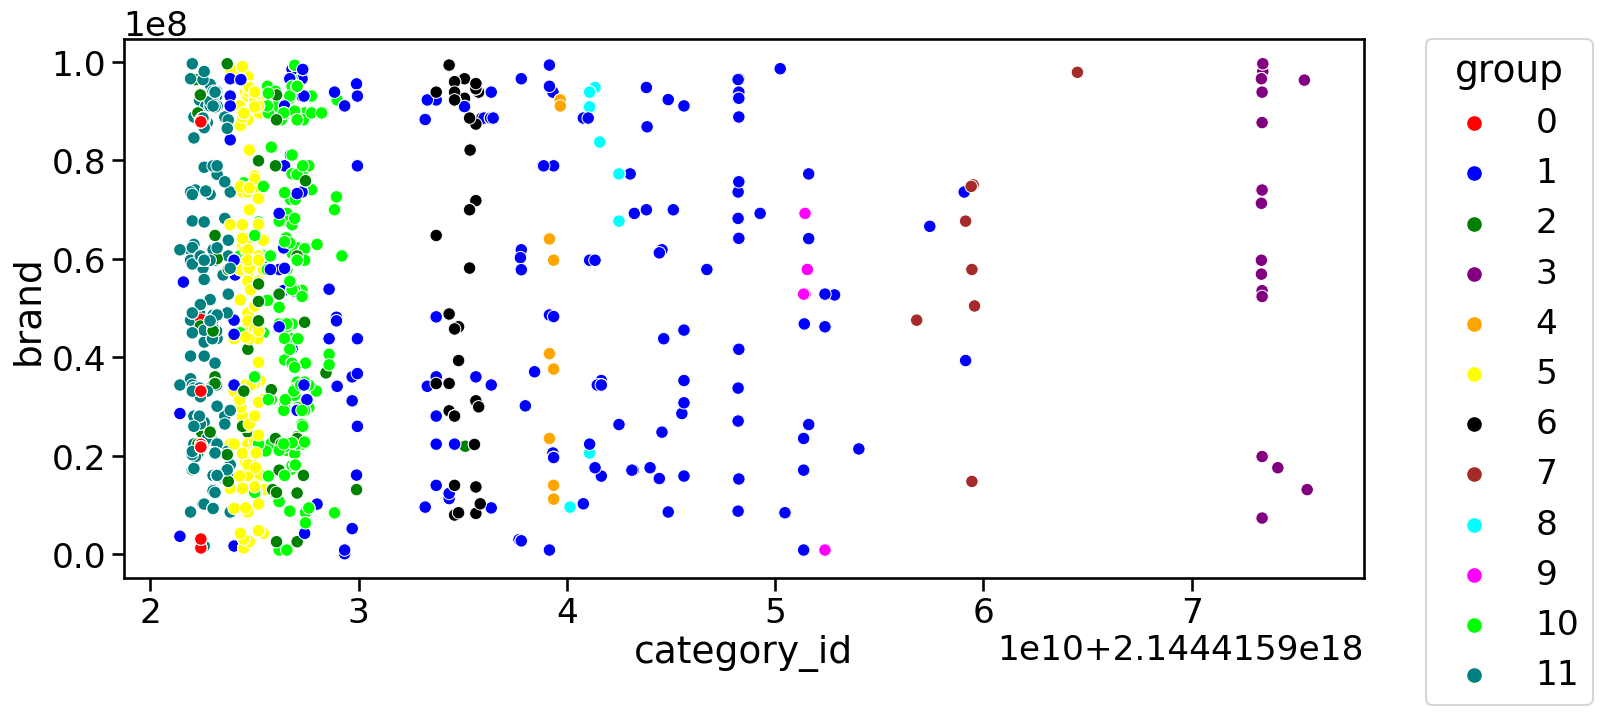

In [60]:
plt.figure(figsize=(16,7))
sns.scatterplot(data=part_df, 
        x="category_id",
        y="brand", 
        hue="predicted_group",
        palette=["red","blue","green","purple","orange","yellow","black","brown","cyan","magenta","lime","teal"])
        # Eight colors couterpart:
        # palette=["red","blue","green","purple","orange","yellow","black","brown"]
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='group', borderaxespad=0)
plt.savefig("./plots/new_GMM_Plot_2D.png",
                    format='png',dpi=150)


Visualization
<br>
Compare to 2D, the 3D PCA plot helps in visualizing the overall structure of the data, identifying clusters or groups of similar data points, and detecting potential outliers in a more comprehensive manner than a 2D PCA plot.

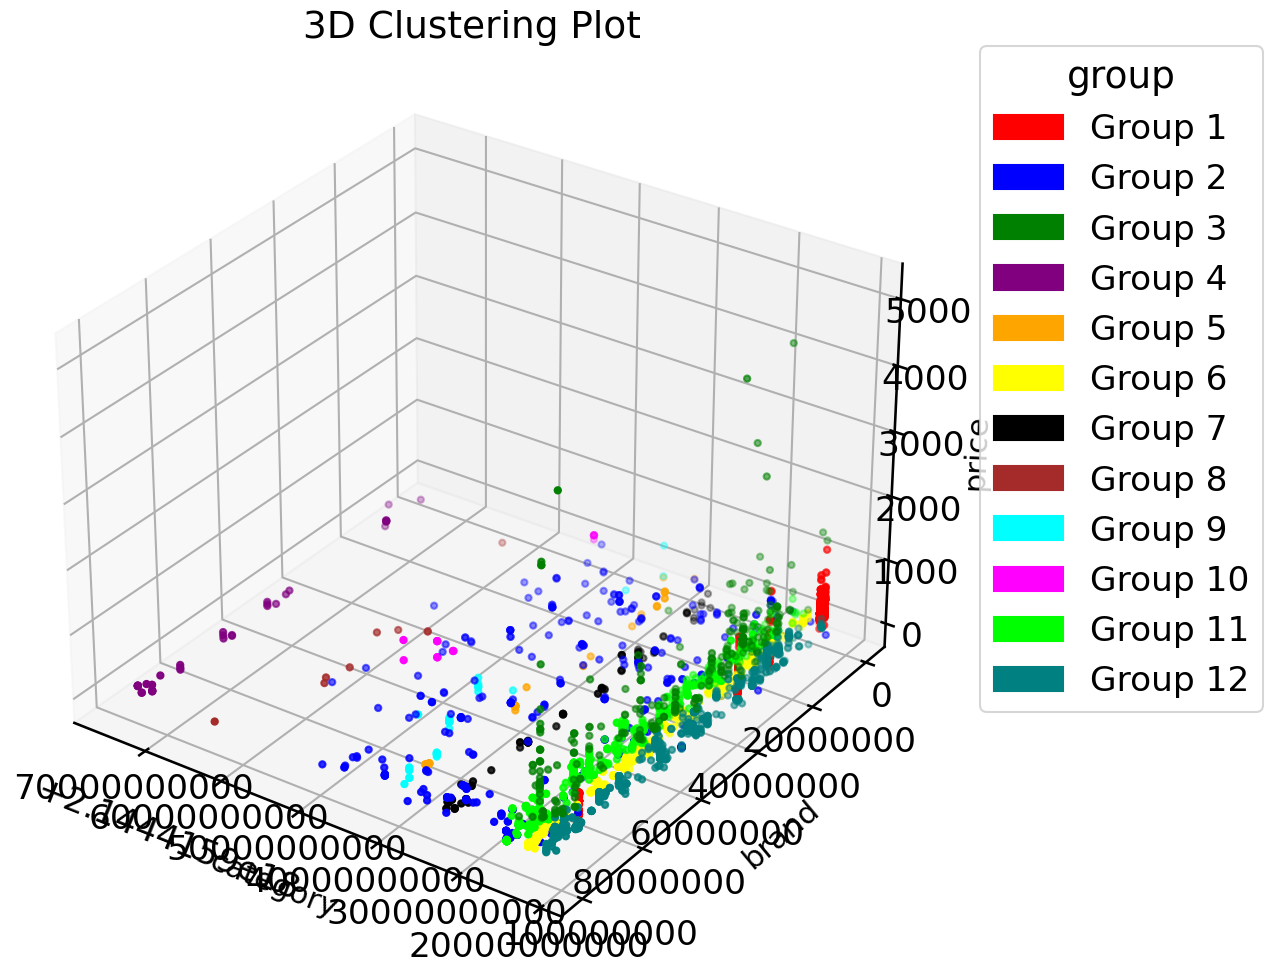

In [94]:
import matplotlib.patches as mpatches

import matplotlib.ticker as ticker

# Custom formatter function
def custom_formatter(x, pos):
    return f"{x:.0f}"




Xax = part_df["category_id"]
Yax = part_df["brand"]
Zax = part_df["price"]

fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111, projection='3d')

color_list = ["red","blue","green","purple","orange","yellow","black","brown","cyan","magenta","lime","teal"]
# Eight color_lits
# ["red","blue","green","purple","orange","yellow","black","brown"]


# Group the data by the predicted group
grouped_data = part_df.groupby('predicted_group')

# Iterate through the grouped data and plot the points for each group with their corresponding color
for group, group_data in grouped_data:
    ax.scatter(group_data["category_id"], group_data["brand"], group_data["price"], c=color_list[group])
    
ax.set_xlabel("category" "", fontsize=22, labelpad=15)
ax.set_ylabel("brand", fontsize=22, labelpad=15)
ax.set_zlabel("price", fontsize=22, labelpad=15)
ax.view_init(30, 125)

# uncomment this line to see the original x-axis, y-axis range
# plt.ticklabel_format(style='plain') 

# Create custom legend elements
legend_elements = [mpatches.Patch(color=color_list[i], label=f'Group {i+1}') for i in range(len(color_list))]

# Add legend to the plot
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title='group', borderaxespad=0)

plt.title("3D Clustering Plot")
plt.savefig("./plots/new_GMM_Plot_3D.png", format='png', dpi=150)
plt.show()

Visulization
<br>
Compare to 2D, the 3D PCA plot helps in visualizing the overall structure of the data, identifying clusters or groups of similar data points, and detecting potential outliers in a more comprehensive manner than a 2D PCA plot.

## **Metrics for GMM**

In [36]:
X = part_df[["product_id","category_id","brand","price"]]
y_pred = part_df["predicted_group"]

# X = gmm_input
# y_pred = gmm.predict(X)


The silhouette score ranges from -1 to 1, with higher values indicating better clustering performance. A silhouette score of 1 means that all data points are well-clustered and separated from other clusters, while a score of -1 means that the clustering is completely wrong, and the data points are better off assigned to a different cluster. Silhouette scores close to 0 indicate overlapping or poorly separated clusters.

The Davies-Bouldin index ranges from 0 to infinity, with lower values indicating better clustering performance. A value of 0 means that the clustering is perfect, while higher values indicate greater separation between clusters.

In [37]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Calculate silhouette score to evaluate clustering performance
silhouette = silhouette_score(X, y_pred)
print("Silhouette score: {:.2f}".format(silhouette))

# Calculate Davies-Bouldin index to evaluate clustering performance
davies_bouldin = davies_bouldin_score(X, y_pred)
print("Davies-Bouldin index: {:.2f}".format(davies_bouldin))

Silhouette score: -0.76
Davies-Bouldin index: 1.03


Akaike Information Criterion (AIC):
AIC is a model selection criterion that measures the goodness-of-fit of a model while penalizing the complexity of the model. Lower AIC values indicate a better model.

Bayesian Information Criterion (BIC):
BIC is another model selection criterion that measures the goodness-of-fit while considering the complexity of the model. It has a stronger penalty for model complexity than AIC. Like AIC, lower BIC values indicate a better model.

In [38]:
import numpy as np
from sklearn.mixture import GaussianMixture

# Calculate AIC and BIC
aic = gmm.aic(X)
bic = gmm.bic(X)

print("AIC:", aic)
print("BIC:", bic)


AIC: 490793.2632502129
BIC: 491919.8981357911


Log-Likelihood:
The log-likelihood measures the probability of observing the data given the model parameters. A higher log-likelihood indicates a better model fit to the data.

In [39]:
# Using the previously fitted GMM model

log_likelihood = gmm.score(X)
print("Log-Likelihood:", log_likelihood)


Log-Likelihood: -61.30440790627661
